In [ ]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from tqdm import tqdm
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat
from lib.datasets.mnist_fid import evaluate_fid_score
def categorical_log_likelihood(x, logits):
    """Log likelihood of a discretized Gaussian specialized for image data.

    Assumes data `x` consists of integers [0, num_classes-1].

    Args:
    x: where to evaluate the distribution. shape = (bs, ...), dtype=int32/int64
    logits: logits, shape = (bs, ..., num_classes)

    Returns:
    log likelihoods
    """
    pass
    #log_probs = nn.log_softmax(logits)
    #x_onehot = nn.one_hot(x, logits.shape[-1])
    #return torch.sum(log_probs * x_onehot, axis=-1)

In [ ]:
max_t = 0.99999
min_t = 0.01
num_steps = [750]
nfe_10_01 = []
for steps in num_steps:
    ts = np.concatenate(
        (np.
        linspace(max_t, min_t, steps), np.array([0]))
    )

    k = 0 
    for i, t in (enumerate(ts[0:-1])):
        #print(i+1)
        if t <= 0.1:
            for j in range(5):
                k += 1
                #print(k)

    nfe_10_01.append(i+1+k)
print(nfe_10_01)

# nfe_1_01 = [54, 109, 272, 545, 818, 1090] 
# nfe_3_01 = [64, 129, 318, 637, 956, 1272]
# nfe_5_01 = [74, 149, 364, 729, 1094, 1454]
# nfe_10_01 = [99, 199, 479, 959, 1439, 1909]

# pc_1_steps = 1 [4, 9, 18, 27, 45, 91] => NFE [5, 10, 20, 30, 50, 100]
# pc_3_steps = [7, 14, 23, 38, 78] => NFE [10, 20, 32, 50, 102]
# pc_5_steps = [10, 20, 33, 67] => NFE [15, 30, 48, 102]

# 1 [229, 458] => 250, 500
# 3 [196, 392]  => 500
# 5 [170, 342]

In [ ]:

n_samples = 15 * 25
#s_name = 'Samples/mnist_unet_LBJF2000.npy'
s_name = 'Samples/MNIST/mnist_unet_corrector5_01_TauL1000.npy' # Samples/MNIST/
samples = np.load(s_name)
samples = samples[550:]
samples = samples.reshape(-1, 1, 28, 28)
#saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
fig = plt.figure(figsize=(15, 25)) 
plt.subplots_adjust(wspace=0.001, hspace=0.001)
int(np.sqrt(n_samples))
for i in range(n_samples):
    plt.subplot(int(25), int(15), 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")

plt.tight_layout()  
plt.savefig('mnist_unet_corrector5_01_TauL1000.pdf', transparent=True)
plt.show()
plt.close()

In [ ]:
path = "SavedModels/MNISTHollow/"  # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = "2024-01-18"  # 2
config_name = "config_001_hollow_direct.yaml"  # config_001_hollowMLEProb.yaml
model_name = "model_519999_hollow_direct.pt"

path = "SavedModels/MNISTHollow/"  # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = "2024-01-03"  # 2
config_name = "config_001_hollow.yaml"  # config_001_hollowMLEProb.yaml
model_name = "model_539999_hollow.pt"

path = "SavedModels/MNIST/"  # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = "2023-12-25"  # 2
config_name = "config_001_unet14Mlogits.yaml"  # config_001_hollowMLEProb.yaml
model_name = "model_599999_unet14Mlogits.pt"

path = "SavedModels/MNIST/"  # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = "2024-01-29"  # 2
config_name = "config_001_unetnll.yaml"  # config_001_hollowMLEProb.yaml
model_name = "model_599999_unetnll.pt"

dataset_location = "lib/datasets"

config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

cfg = bookkeeping.load_config(config_path)
cfg.data.train = False
"""
if cfg.loss.name == 'CatRM':
    cfg.loss.name = 'SDDMNLL'
elif cfg.loss.name == 'CTElbo':
    cfg.loss.name = 'TauLDRNLL'
else:
    raise KeyError("Eval not defined!")

cfg.training.train_step_name = 'EvalMNIST'
"""
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)

optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}

state = bookkeeping.load_state(state, checkpoint_path)
cfg.training.n_iters = 600000
cfg.sampler.sample_freq = 100000000
cfg.saving.checkpoint_freq = 10000
cfg.sampler.num_steps = 1000

# EvalMNIST

loss = losses_utils.get_loss(cfg)

training_step = training_utils.get_train_step(cfg)

# sampler = sampling_utils.get_sampler(cfg)


print("Info:")
print("--------------------------------")
print("State Iter:", state["n_iter"])
print("--------------------------------")
print("Name Dataset:", cfg.data.name)
print("Loss Name:", cfg.loss.name)

print("--------------------------------")
print("Model Name:", cfg.model.name)
print("Number of Parameters: ", sum([p.numel() for p in model.parameters()]))

model.eval()
# 66.52994572680203  # Inception mean:  7.715643802044586
# Inception std:  0.18737017997662175

In [ ]:
"""
n_rounds = 150
nll = []
dataset = dataset_utils.get_dataset(cfg, device, dataset_location)

dataloader = torch.utils.data.DataLoader(dataset,
    batch_size=cfg.data.batch_size,
    shuffle=cfg.data.shuffle)

for i, minibatch in tqdm(enumerate(tqdm(dataloader))):
    minibatch = minibatch.to(device)
    l = training_step.step(state, minibatch.long(), loss)
    nll.append(l.item())

    if i >= n_rounds:
        print("Avg NLL:", np.mean(nll))
        break
"""

In [ ]:
steps = [1000]

cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.is_ordinal = True
sampler_names = ['MidPointTauL'] # 'CRMLBJF', 
n_samples = 1000
for _, n_name in enumerate(sampler_names):
    cfg.sampler.name = n_name 
    print("# name:", cfg.sampler.name)
    for _, n_steps in enumerate(steps):
        cfg.sampler.num_steps = n_steps
        print("# step:", cfg.sampler.num_steps)
        for i in range(10):
            sampler = sampling_utils.get_sampler(cfg)
            samples, changes_jump, = sampler.sample(model, n_samples)
            saved_samples = samples
            print(f'mnist_unet_nll_{cfg.sampler.name}{cfg.sampler.num_steps}_mnist{i}')
            np.save(f'mnist_unet_nll_{cfg.sampler.name}{cfg.sampler.num_steps}_mnist{i}', saved_samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size))


In [ ]:
# pc_1_steps = 1 [4, 9, 18, 27, 45, 91] => NFE [5, 10, 20, 30, 50, 100]
# pc_3_steps = [7, 14, 23, 38, 78] => NFE [10, 20, 32, 50, 102]
# pc_5_steps = [10, 20, 33, 67] => NFE [15, 30, 48, 102]
# 1 [229, 458] => 250, 500
# 3 [196, 392]  => 500
# 5 [170, 342]

cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.1)
#cfg.sampler.num_steps = 10
cfg.sampler.is_ordinal = True
steps=[750]
sampler_names = ['TauL'] # 'CRMLBJF', 
n_samples = 1000
for _, n_name in enumerate(sampler_names):
    cfg.sampler.name = n_name 
    print("# name:", cfg.sampler.name)
    for pc in [5]:
        cfg.sampler.num_corrector_steps = pc
        for _, n_steps in enumerate(steps):
            cfg.sampler.num_steps = n_steps
            print("# step:", cfg.sampler.num_steps)
            for i in range(10):
                sampler = sampling_utils.get_sampler(cfg)
                samples, changes = sampler.sample(model, n_samples)
                saved_samples = samples
                np.save(f'mnist_unet_nll_corrector{pc}_01_{cfg.sampler.name}{cfg.sampler.num_steps}_{i}', saved_samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size))


In [ ]:

steps = [1000]
sampler_name = ['TauL', 'LBJF']# , CRMTauL']
for sampler_n_i in sampler_name:
    for step in steps:
        data_list = []
        for i in range(10):
            print(f'mnist_unet_nll_{sampler_n_i}{step}_mnist{i}.npy')
            data_list.append(np.load(f'mnist_unet_nll_{sampler_n_i}{step}_mnist{i}.npy'))
        data = np.vstack(data_list)
        print(data.shape)
        np.save(f'Samples/MNIST/mnist_unet_nll_{sampler_n_i}{step}.npy', data)

In [ ]:
steps = [1000] 
sampler_names = ['MidPointTauL']# , 'CRMTauL', 'ExactSampling' ] # 'LBJF', 
#for sampler_n_i in sampler_name:
#    for step in steps:
cfg.data.train = False
#        data = np.load(f'unet_{sampler_n_i}{step}_mnist.npy')

for sampler_n in sampler_names:
    fid_values = []
    for step in steps:
        data = np.load(f'Samples/MNIST/mnist_unet_{sampler_n}{step}_prime.npy')
        #data = np.load('mpl_x.npy')
        print(data.shape)
        dataset = dataset_utils.get_dataset(cfg, device, dataset_location)

        dataloader = torch.utils.data.DataLoader(dataset,
            batch_size=data.shape[0],
            shuffle=cfg.data.shuffle)
        for true_data in tqdm(dataloader):
            #print(f'mnist_hollow_{sampler_n}{step}.npy')
            print("----------------------------------")
            print("Sampler:", sampler_n)
            print("Step:", step)
            fid = evaluate_fid_score(data, true_data.cpu().numpy(), 100)
            print("FID:", fid)
            fid_values.append(fid)
            break
    print(fid_values)

# TauL: FID NLL: 1.84 
# Inception mean:  8.34013123189316,
# Inception std:  0.08751290738691128
# LBJF: 6,47
# # Inception mean:  6.67265301843486
# Inception std:  0.09073312162694455
    
#Lelambda TauL: 2.4; 8,78 , LBJF 20; 7.31

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4

# FID
steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500, 1000, 2000]), 4)
steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 1500])
fid_taul = np.array([369.82769160402194, 339.7123739152373, 283.87526811768316, 212.90508021598973, 120.04226304249106, 40.6234648618652, 13.453524786963495, 3.6, 2.98404509903506, 2.5895556730263706, 2.51, 2.48, 2.460157370950734])
fid_lbjf = np.array([369.82769160402194, 368.6921461974128, 367.43394813969206, 363.92216793023744, 360.795573791034, 354.6901690476625, 339.59518918406286, 305.2288604477556, 212.0276736955564, 75.84530505097865, 32.956622302615955, 19.817409823054646, 7.19])
fid_mpl = np.array([344.39284875166595, 290.45552043389864, 247.32958569058357, 88.0448768470724, 42.82853224434638, 12.394969584434108, 4.020041973904654, 3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.5, 2.4493237174940248, 2.40])

fig = plt.figure(figsize=(width, height))
plt.plot(steps, fid_taul, marker='o', color='green', label='Tau-Leaping', markersize=marker_size, linewidth=line_width)
plt.plot(steps, fid_lbjf, marker='o', label='Euler', markersize=marker_size, linewidth=line_width)
plt.plot(steps, fid_mpl, marker='o', label='MP Tau-Leaping', color='lightcoral', markersize=marker_size, linewidth=line_width)
plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('FID $\\downarrow$', fontsize=13)
plt.title('FID of Sampling Methods for Varying $\\tau$', fontsize=14)
plt.legend(fontsize=9)
plt.grid(True)
plt.xscale('log')
steps_y = [370, 250, 150, 100, 45, 30, 20, 7.0, 4.0, 2.5]
plt.yscale('log')
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
#plt.tight_layout()  # Fügt diese Zeile hinzu, um den Rahmen näher an das x-Label zu bringen
plt.savefig('fid_tau.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('$\\tau$', fontsize=13)], pad_inches=0.03)
plt.show()

In [ ]:
# IS 
import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4

steps_plot = np.round(1 / np.array([5, 10, 20, 50, 100, 250, 500, 1000, 2000]), 4)
mean_is_mpl = np.array([8.56, 8.62, 8.677, 8.7, 8.733, 8.763])
std_is_mpl = np.array([0.078, 0.1, 0.079, 0.06, 0.057, 0.075])
# 30-60, 50-100, 100-200, 250-500, 500-1000, 750, 1500

steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 1500])
print(len(steps))
mean_is_taul = np.array([2.19, 2.22, 2.708047858197907, 3.86, 4.946, 6.260149524787618, 7.725075911310337, 8.600311295819452, 8.695352062102907, 8.730387442552915, 8.76098102664333, 8.785004667417176, 8.789941441541984])
std_is_taul = np.array([0.029, 0.027, 0.035763717879784655, 0.07, 0.09223751449123928, 0.05542292679137494, 0.07471893518876059, 0.11749863261977536, 0.05961257597104094, 0.057613531976108634, 0.06736065870254852, 0.07408158674264428, 0.07343111567356189])

mean_is_lbjf = np.array([2.197, 2.1935, 2.1905016592910244, 2.21, 2.233561128867508, 2.2720786975418426, 2.3474579482515194, 2.703195286772994, 4.422914663421897, 6.212356745289218, 7.003172870037281, 7.3776977749287855, 8.086100926383237])
std_is_lbjf = np.array([0.017, 0.028, 0.016885548328526935, 0.023, 0.01655479275116797, 0.01665546477191724, 0.021260056132834024, 0.042065063979126655, 0.0653358704449712, 0.08250910888402853, 0.09807975265868278, 0.11617335996188316, 0.07638698691732632])

mean_is_mpl = np.array([2.44, 3.01, 3.92, 5.575, 6.35, 7.779, 8.56, 8.65, 8.7, 8.745, 8.763, 8.795, 8.8])
std_is_mpl = np.array([0.019, 0.0633, 0.046, 0.0665, 0.0776, 0.087, 0.078, 0.1, 0.079, 0.06, 0.075, 0.082, 0.072])
print(len(mean_is_mpl), len(mean_is_taul), len(mean_is_lbjf), len(std_is_mpl), len(std_is_taul), len(std_is_lbjf))


fig = plt.figure(figsize=(width, height))
plt.plot(steps, mean_is_taul, marker='o', color='green', label='Tau-Leaping', markersize=marker_size, linewidth=line_width)
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_taul, std_is_taul)],
                 [mean + std for mean, std in zip(mean_is_taul, std_is_taul)],
                 alpha=0.3, color='green')
plt.plot(steps, mean_is_lbjf, marker='o', label='Euler', markersize=marker_size, linewidth=line_width)
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_lbjf, std_is_lbjf)],
                 [mean + std for mean, std in zip(mean_is_lbjf, std_is_lbjf)],
                 alpha=0.3)

plt.plot(steps, mean_is_mpl, marker='o', label='MP Tau-Leaping', color='lightcoral', markersize=marker_size, linewidth=line_width)
plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_mpl, std_is_mpl)],
                 [mean + std for mean, std in zip(mean_is_mpl, std_is_mpl)],
                 alpha=0.3)

plt.xlabel('$\\tau$', fontsize=13)
plt.ylabel('IS $\\uparrow$', fontsize=13)
plt.title('IS of Sampling Methods for Varying $\\tau$', fontsize=14)
plt.legend(fontsize=9)
plt.grid(True)
plt.xscale('log')
#plt.yscale('log')

steps_y = [8.8, 8.0,7.0,6.0,5.0,4.0,3.0,2.0]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.savefig('inception_score_tau.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('$\\tau$', fontsize=13)], pad_inches=0.03)
plt.show()



In [ ]:
# NFE FID

import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4

nfe_mpl = [100, 200, 500, 1000, 1250, 1500]
nfe_taul = [100, 250, 500, 750, 1000, 1250, 1500]

# steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 2000])
nfe_mpl = [100, 200, 500, 1000, 1250, 1500]
nfe_taul = [100, 250, 500, 750, 1000, 1250, 1500]
fid_taul = np.array([3.6, 2.98404509903506, 2.5895556730263706, 2.51, 2.48, 2.47, 2.460157370950734])
fid_mpl = np.array([4.020041973904654, 3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.52, 2.5])


nfe_taul_5100 = [10, 20, 30, 50, 100]# , 250, 500, 750, 1000, 1500], 2.98404509903506, 2.5395556730263706, 2.51, 2.48, 2.460157370950734])
nfe_mpl_5100 = [10, 20, 30, 40, 60, 100]#, 200, 500, 1000, 1500]
fid_taul_5100 = np.array([283.87526811768316, 120.04226304249106, 40.6234648618652, 13.453524786963495, 3.6]) # 2.98404509903506, 2.5895556730263706, 2.51, 2.48, 2.460157370950734])
fid_mpl_5100 = np.array([344.39284875166595, 247.32958569058357, 88.0448768470724, 42.82853224434638, 12.394969584434108, 4.020041973904654]) #3.3680633408595213, 2.8853011388733307, 2.5683849558007807, 2.5])


#steps_plot = 
fig = plt.figure(figsize=(width, height))
plt.plot(nfe_taul, fid_taul, marker='o', color='green', label='Tau-Leaping', markersize=marker_size, linewidth=line_width)
plt.plot(nfe_mpl, fid_mpl, marker='o', label='Midpoint Tau-Leaping', color='lightcoral', markersize=marker_size, linewidth=line_width)
#plt.plot(nfe_1_01, nfe_1_01_fid, marker='o', label='Tau-Leaping C1')
#plt.plot(nfe_3_01, nfe_3_01_fid, marker='o', label='Tau-Leaping C3')
#plt.plot(nfe_5_01, nfe_5_01_fid, marker='o', label='Tau-Leaping C5')
#plt.plot(nfe_10_01, nfe_10_01_fid, marker='o', label='Tau-Leaping C10')

steps_y = [4.0, 3.6, 3.4, 3.0, 2.8, 2.57, 2.46]
steps_plot = [100, 250, 500, 750, 1000, 1250, 1500]
plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID $\downarrow$', fontsize=13)
plt.title('FID of Tau-Leaping Methods for Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
#
plt.savefig('fid_nfe_mp_taul_10100.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('NFE', fontsize=13)], pad_inches=0.03)
plt.show()

#steps_plot = 
fig = plt.figure(figsize=(width, height))
plt.plot(nfe_taul_5100, fid_taul_5100, marker='o', color='green', label='Tau-Leaping', markersize=marker_size, linewidth=line_width)
plt.plot(nfe_mpl_5100, fid_mpl_5100, marker='o', label='Midpoint Tau-Leaping', color='lightcoral', markersize=marker_size, linewidth=line_width)
#plt.plot(nfe_1_01, nfe_1_01_fid, marker='o', label='Tau-Leaping C1')
#plt.plot(nfe_3_01, nfe_3_01_fid, marker='o', label='Tau-Leaping C3')
#plt.plot(nfe_5_01, nfe_5_01_fid, marker='o', label='Tau-Leaping C5')
#plt.plot(nfe_10_01, nfe_10_01_fid, marker='o', label='Tau-Leaping C10')
plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID $\downarrow$', fontsize=13)
plt.title('FID of Tau-Leaping Methods for Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)
plt.yscale('log')
steps_y_5100 = [345, 245, 125, 40, 14, 3.5]
steps_plot_5100 = [10, 15, 20, 30, 50, 100]
plt.yticks(steps_y_5100, steps_y_5100)
plt.xticks(steps_plot_5100, steps_plot_5100)
#
plt.savefig('fid_nfe_mp_taul_1001500.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('NFE', fontsize=13)], pad_inches=0.03)
plt.show()


In [ ]:
# NFE IS
from matplotlib.ticker import FormatStrFormatter
marker_size = 4
line_width = 1.5
mean_is_taul = np.array([8.600311295819452, 8.695352062102907, 8.730387442552915, 8.76098102664333, 8.785004667417176, 8.787, 8.789941441541984])
std_is_taul = np.array([0.11749863261977536, 0.05961257597104094, 0.057613531976108634, 0.06736065870254852, 0.07408158674264428, 0.056, 0.07343111567356189])

mean_is_mpl = np.array([8.56, 8.65, 8.7, 8.745, 8.753, 8.763])
std_is_mpl = np.array([0.078, 0.1, 0.079, 0.06, 0.057, 0.075])
#50-100, 100-200, 250-500, 500-1000, 750, 1500

steps = 1 / np.array([5, 7, 10, 15, 20, 30, 50, 100, 250, 500, 750, 1000, 1500])

nfe_mpl = [100, 200, 500, 1000, 1250, 1500]
nfe_taul = [100, 250, 500, 750, 1000, 1250, 1500]

fig = plt.figure(figsize=(width, height))
plt.plot(nfe_taul, mean_is_taul, marker='o', color='green', label='Tau-Leaping', markersize=marker_size, linewidth=line_width)
#plt.fill_between(nfe_taul, [mean - std for mean, std in zip(mean_is_taul, std_is_taul)],[mean + std for mean, std in zip(mean_is_taul, std_is_taul)],alpha=0.3, color='green')

plt.plot(nfe_mpl, mean_is_mpl, marker='o', label='MidPoint Tau-Leaping', color='lightcoral', markersize=marker_size, linewidth=line_width)
#plt.fill_between(nfe_mpl, [mean - std for mean, std in zip(mean_is_mpl, std_is_mpl)],[mean + std for mean, std in zip(mean_is_mpl, std_is_mpl)],alpha=0.3)
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 

plt.xlabel('NFE', fontsize=13)
plt.ylabel('IS $\\uparrow$', fontsize=13)
plt.title('IS of Tau-Leaping Methods for Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)
steps_plot = [100, 250, 500, 750, 1000, 1250, 1500]
steps_y = [8.56, 8.6,8.65, 8.70, 8.73, 8.76, 8.79]
#plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.yticks(steps_y, ['%.2f' % val for val in steps_y])
plt.savefig('inception_score_mp_tau_1001500.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('NFE', fontsize=13)], pad_inches=0.03)
plt.show()

steps_taul = [10, 20, 30, 50, 100]
print(len(steps))
mean_is_taul = np.array([2.708047858197907, 4.946, 6.260149524787618, 7.725075911310337, 8.600311295819452])
std_is_taul = np.array([0.035763717879784655, 0.09223751449123928, 0.05542292679137494, 0.07471893518876059, 0.11749863261977536])
# 10, 20, 
mean_is_mpl = np.array([2.44, 3.92, 5.575, 6.35, 7.779, 8.56])
std_is_mpl = np.array([0.019, 0.046, 0.0665, 0.0776, 0.087, 0.078])
# 10, 20, 30, 40, 60, 100
steps_mptaul = [10, 20, 30, 40, 60, 100]

fig = plt.figure(figsize=(width, height))
plt.plot(steps_taul, mean_is_taul, marker='o', color='green', label='Tau-Leaping', markersize=marker_size, linewidth=line_width)
#plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_taul, std_is_taul)], [mean + std for mean, std in zip(mean_is_taul, std_is_taul)], alpha=0.3, color='green')

plt.plot(steps_mptaul, mean_is_mpl, marker='o', label='MP Tau-Leaping', color='lightcoral', markersize=marker_size, linewidth=line_width)
#plt.fill_between(steps, [mean - std for mean, std in zip(mean_is_mpl, std_is_mpl)],[mean + std for mean, std in zip(mean_is_mpl, std_is_mpl)], alpha=0.3)

plt.xlabel('NFE', fontsize=13)
plt.ylabel('IS $\\uparrow$', fontsize=13)
plt.title('IS of Tau-Leaping Methods for Varying NFE', fontsize=14)
plt.legend()
plt.grid(True)
steps_plot = [10, 20, 30, 40, 50, 60, 100]
steps_y = [2.4, 4.0, 5.0, 6.3, 7.5, 8.5]
#plt.yscale('log')
plt.xticks(steps_plot, steps_plot)
plt.yticks(steps_y, steps_y)
plt.savefig('inception_score_mp_tau_10100.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('NFE', fontsize=13)], pad_inches=0.03)
plt.show()

In [ ]:
print(steps[:-1])

In [ ]:
# 0: 75:  4.3245049017693304
# 1: 250, 500: [5.845140920974131, 2.252598541276768, 2.3627632134412977]
# 3: 250, 500, [9.18351245256298 2.3423048205916643, [[2.3001590957738642]]
# 5: 75, 250, 500, [12.95, 2.3731947632869037, 2.418666817264665]

# 5: 10, 16, 22, 25, 30, 48, 75, 102
# 3: 10, 14, 20, 32, 50, 75, 102
# 1: 10, 15, 20, 30, 50, 

# 100-1500
import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4
"""
pc_1_steps =[5, 10, 20, 30, 50, 100, 818]#, 1000, 1250, 1500]
nfe_01_1_fid = [355.30401756086303, 299.8788404145761, 220.94562240586495, 63.526149427266375, 17.06536557569376, 2.813092226544086, 2.27897546009885]#8, 2.2671159746989906, 2.259, 2.252]
pc_3_steps = [10, 20, 32, 50, 102, 637]#7, 1000, 1250, 1500]
nfe_01_3_fid = [368.2020780292752, 306.44852994200113, 105.99785122999572, 23.8096318610784, 3.8135712497214342, 2.276187915395326]#, 2.2539787186312788, 2.2466063307386435, 2.238]
pc_5_steps =[15, 30, 48, 102, 729]#, 1000, 1250, 1500]
nfe_01_5_fid = [308.4621460802384, 153.52888664861723, 32.976239962089096, 5.501552200792844, 2.2559381898192896]#, 2.2450412804101074, 2.234, 2.2267139529323856]
"""
# 1: 250, 500: [2.252598541276768, 2.3627632134412977]
# 3: [2.3423048205916643, [3.9064362368672505]

pc_1_steps =[15, 20, 30, 50, 75, 100, 250]
nfe_01_1_fid = [258.788404145761, 210.94562240586495, 63.526149427266375, 17.06536557569376, 5.845140920974131, 2.813092226544086, 2.3627632134412977]
pc_3_steps = [14, 20, 32, 50, 75, 102, 250]
nfe_01_3_fid = [328.2020780292752, 278.44852994200113, 105.99785122999572, 23.8096318610784, 9.18351245256298, 3.8135712497214342, 2.3923048205916643]
pc_5_steps =[16, 20, 30, 48, 75, 102, 250]
nfe_01_5_fid = [348.4621460802384, 320, 153.52888664861723, 32.976239962089096, 12.95, 5.501552200792844, 2.418666817264665]

steps = np.array([15, 20, 30, 50, 75, 100, 250]) # , 250, 500, 750, 1000, 1500])
fid_taul = np.array([212.90508021598973, 120.04226304249106, 40.6234648618652, 13.453524786963495, 4.3245049017693304, 3.6, 2.98404509903506])#, 2.98404509903506, 2.5895556730263706, 2.51, 2.48, 2.460157370950734])

steps = steps[:-1]
pc_1_steps = pc_1_steps[:-1]
pc_3_steps = pc_3_steps[:-1]
pc_5_steps = pc_5_steps[:-1]
fid_taul = fid_taul[:-1]
nfe_01_1_fid = nfe_01_1_fid[:-1]
nfe_01_3_fid = nfe_01_3_fid[:-1]
nfe_01_5_fid = nfe_01_5_fid[:-1]
colors = ['black', 'gray', 'lightgray']
colors = ['black', 'gray', (0.7, 0.7, 0.7)]  
colors = ['black', (0.39, 0.39, 0.39), (0.7, 0.7, 0.7)]  # Graustufen-Farben

fig = plt.figure(figsize=(width, height))
plt.plot(steps, fid_taul, marker='o', color='green', label='Tau-Leaping', markersize=marker_size, linewidth=line_width)
plt.plot(pc_1_steps, nfe_01_1_fid, marker='o', label='Tau-Leaping Corrector-Steps: 1', color=colors[2], markersize=marker_size, linewidth=line_width)
plt.plot(pc_3_steps, nfe_01_3_fid, marker='o', label='Tau-Leaping Corrector-Steps: 3', color=colors[1], markersize=marker_size, linewidth=line_width)
plt.plot(pc_5_steps, nfe_01_5_fid, marker='o', label='Tau-Leaping Corrector-Steps: 5', color=colors[0], markersize=marker_size, linewidth=line_width)

plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID $\downarrow$', fontsize=13)
plt.title('FID Score of Tau-Leaping for Different Corrector-Steps', fontsize=14)
plt.legend()
plt.grid(True)

plt.yscale('log')
steps_y = [350, 250, 150, 100, 50, 30, 20, 10, 6.0, 4.0, 2.5]
steps_plot = [15, 20, 30, 50, 75, 100]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.savefig('fid_nfe_corrector_15100.pdf', format='pdf',bbox_inches="tight", transparent=True)
plt.show()

In [ ]:
#plt.plot(nfe_mpl, fid_mpl, marker='o', label='Midpoint Tau-Leaping')
import numpy as np
import matplotlib.pyplot as plt
marker_size = 4
line_width = 1.5
width = 6.4
height= 2.4

# 0: 75:  4.3245049017693304
# 1: 250, 500: [5.845140920974131, 2.252598541276768, 2.3627632134412977]
# 3: 250, 500, [9.18351245256298 2.3423048205916643, [[2.3001590957738642]]
# 5: 75, 250, 500, [12.95, 2.3731947632869037, 2.418666817264665]

colors = ['black', 'gray', 'lightgray']
colors = ['black', 'gray', (0.7, 0.7, 0.7)]  
colors = ['black', (0.39, 0.39, 0.39), (0.7, 0.7, 0.7)]  # Graustufen-Farben
fid_taul2 = np.array([2.98404509903506, 2.5395556730263706, 2.51, 2.48, 2.47, 2.460157370950734])
nfe_taul2 = [250, 500, 750, 1000, 1250, 1500]

nfe_1_01 = [250, 350, 500, 750, 1000, 1250, 1500] # 1090 last
nfe_1_01_fid = [2.36, 2.3324636154390714,  2.301, 2.288, 2.2711159746989906, 2.259, 2.252]
nfe_3_01 = [250, 350, 500, 750, 1000, 1250, 1500] # vorletzes 956 # 1272
nfe_3_01_fid = [2.392, 2.35941289542929, 2.28, 2.269187915395326, 2.2539787186312788, 2.2466063307386435, 2.238]
nfe_5_01 = [250, 350, 500, 750, 1000, 1250, 1500] #vorletztes 1094 letztes 15000
nfe_5_01_fid = [2.41, 2.3770141451028314, 2.295, 2.2589381898192896, 2.2450412804101074, 2.234, 2.2267139529323856]

nfe_taul2 = nfe_taul2

fig = plt.figure(figsize=(width, height))
plt.plot(nfe_taul2, fid_taul2, marker='o', color='green', label='Tau-Leaping Corrector-Steps: 0', markersize=marker_size, linewidth=line_width)
plt.plot(nfe_1_01, nfe_1_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 1', color=colors[2], markersize=marker_size, linewidth=line_width)
plt.plot(nfe_3_01, nfe_3_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 3', color=colors[1], markersize=marker_size, linewidth=line_width)
plt.plot(nfe_5_01, nfe_5_01_fid, marker='o', label='Tau-Leaping Corrector-Steps: 5', color=colors[0], markersize=marker_size, linewidth=line_width)

plt.xlabel('NFE', fontsize=13)
plt.ylabel('FID $\downarrow$', fontsize=13)
plt.title('FID Score of Tau-Leaping for Different Corrector-Steps', fontsize=14)
plt.legend()
plt.grid(True)

plt.yscale('log')
steps_y = [3, 2.9, 2.8, 2.7, 2.65, 2.6, 2.54, 2.5, 2.4, 2.45, 2.30, 2.26, 2.23]
steps_y = [2.4, 2.375, 2.35, 2.325, 2.3, 2.275, 2.25, 2.24, 2.225]
steps_y = [3.0, 2.9, 2.8, 2.7, 2.6, 2.5, 2.4, 2.3, 2.2]
steps_plot = [250, 350, 500, 750, 1000, 1250, 1500]
plt.yticks(steps_y, steps_y)
plt.xticks(steps_plot, steps_plot)
plt.savefig('fid_nfe_corrector_250500.pdf', format='pdf',bbox_inches="tight", transparent=True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
width = 6.4
height= 2.4
# state changes TauL: mnist

#np.save('PNGs/state_changes_taul.npy', changes.detach().cpu().numpy())
s_changes_taul = np.load('PNGs/MNIST/state_changes_taul.npy')
#changes[-1, 0, :].reshape(28,28)
shaped_changes = s_changes_taul[:, 0, :].reshape(-1, 28,28)
indices = np.where((shaped_changes[-1, :, :] > 20) & (shaped_changes[-1, :, :] < 250))
print(indices[0])
print(indices[1])
steps = np.linspace(1, 0, 1000)


#for i in range(max_number):
fig = plt.figure(figsize=(width, height))
plt.gca().invert_xaxis()
plt.plot(steps, shaped_changes[:, 14, 14])
plt.plot(steps, shaped_changes[:, 9, 8])
plt.plot(steps, shaped_changes[:, 10, 10])
##plt.plot(steps, shaped_changes[:, 13, 7])
#plt.plot(steps, shaped_changes[:, 24, 20])
# plt.plot(steps, shaped_changes[:, 11, 20], label='neu') # gut
plt.plot(steps, shaped_changes[:, 11, 9], label='neu')
plt.xlabel('Time', fontsize=13)
plt.ylabel('State',fontsize=13)
plt.legend()
plt.title('State Changes during Reverse Process', fontsize=14)
plt.grid(True)
steps_x = [1.0, 0.8, 0.6, 0.4, 0.2, 0]
plt.xticks(steps_x, steps_x)
plt.savefig('state_changes_taul.pdf', format='pdf',bbox_inches="tight", transparent=True,  bbox_extra_artists=[plt.xlabel('Time', fontsize=13)], pad_inches=0.03)
plt.show()


In [ ]:
import plotly.graph_objs as go

# Daten für die zusätzlichen Plots
trace1 = go.Scatter(x=steps, y=shaped_changes[:, 14, 14], mode='lines', name='State Changes 1')
trace2 = go.Scatter(x=steps, y=shaped_changes[:, 9, 8], mode='lines', name='State Changes 2')
trace3 = go.Scatter(x=steps, y=shaped_changes[:, 10, 10], mode='lines', name='State Changes 3')
trace4 = go.Scatter(x=steps, y=shaped_changes[:, 24, 20], mode='lines', name='State Changes 4')


layout = go.Layout(
    title='State Changes during Reverse Process',
    xaxis=dict(title='Time', tickvals=[1.0, 0.8, 0.6, 0.4, 0.2, 0], ticktext=[1.0, 0.8, 0.6, 0.4, 0.2, 0], autorange="reversed"),
    yaxis=dict(title='State'),  # Invert y-axis
    legend=dict(x=0.7, y=1),
    showlegend=True
)

# Hinzufügen aller Traces zur figure
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()

In [ ]:
# state changes LBJF: mnist
width = 6.4
height= 2.4
#np.save('PNGs/state_changes_lbjf.npy', changes)
s_changes_lbjf = np.load('PNGs/MNIST/state_changes_lbjf.npy')
#changes[-1, 0, :].reshape(28,28)
shaped_changes = s_changes_lbjf[:, 0, :].reshape(-1, 28,28)
indices = np.where((shaped_changes[-1, :, :] > 20) & (shaped_changes[-1, :, :] < 250))
print(indices[0])
print(indices[1])
steps = np.linspace(1, 0, 1000)

#for i in range(max_number):

fig = plt.figure(figsize=(width, height))
plt.gca().invert_xaxis()
plt.plot(steps, shaped_changes[:, 10, 13])
plt.plot(steps, shaped_changes[:, 7, 18])
#plt.plot(steps, shaped_changes[:, 9, 12])
plt.plot(steps, shaped_changes[:, 25, 10])
plt.plot(steps, shaped_changes[:, 17, 14])
plt.xlabel('Time', fontsize=13)
plt.ylabel('State',fontsize=13)
plt.legend()
#plt.title('State Changes during Reverse Process', fontsize=14)
plt.grid(True)
steps_x = [1.0, 0.8, 0.6, 0.4, 0.2, 0]
plt.xticks(steps_x, steps_x)
plt.title('State Changes during Reverse Process', fontsize=14)
plt.savefig('state_changes_lbjf.pdf', format='pdf',bbox_inches="tight", transparent=True, bbox_extra_artists=[plt.xlabel('Time', fontsize=13)], pad_inches=0.03)
plt.show()

In [ ]:
# multiple jumps in a single dim: MNIST
width = 6.4
height= 2.4
#np.save('PNGs/jumps_over_1_taul.npy', changes)
changes_jump_over1 = np.load('PNGs/MNIST/jumps_over_1_taul.npy')
steps = np.linspace(1, 0, len(changes_jump_over1[:-1]))


fig = plt.figure(figsize=(width, height))
plt.gca().invert_xaxis()
plt.plot(steps, changes_jump_over1[:-1], color='black')
plt.xlabel('Time', fontsize=13)
plt.ylabel('Prop. of Multiple Jumps', fontsize=13)
plt.title('Avg. Proportion of Multiple Jumps in one Dimension', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('jumps_over_1_taul.pdf', format='pdf',bbox_inches="tight", transparent=True,  bbox_extra_artists=[plt.xlabel('Time', fontsize=13)], pad_inches=0.03)
plt.show()


In [ ]:
import plotly.graph_objs as go

# Daten laden
s_changes_lbjf = np.load('PNGs/MNIST/state_changes_lbjf.npy')
shaped_changes = s_changes_lbjf[:, 0, :].reshape(-1, 28, 28)
indices = np.where((shaped_changes[-1, :, :] > 20) & (shaped_changes[-1, :, :] < 250))
steps = np.linspace(1, 0, 1000)

# Plots erstellen
trace1 = go.Scatter(x=steps, y=shaped_changes[:, 10, 13], mode='lines', name='State Changes 1')
trace2 = go.Scatter(x=steps, y=shaped_changes[:, 7, 18], mode='lines', name='State Changes 2')
trace3 = go.Scatter(x=steps, y=shaped_changes[:, 25, 10], mode='lines', name='State Changes 3')
trace4 = go.Scatter(x=steps, y=shaped_changes[:, 17, 14], mode='lines', name='State Changes 4')
trace4 = go.Scatter(x=steps, y=shaped_changes[:, 17, 14], mode='lines', name='State Changes 4')

layout = go.Layout(
    xaxis=dict(title='Time', tickvals=[1.0, 0.8, 0.6, 0.4, 0.2, 0], ticktext=[1.0, 0.8, 0.6, 0.4, 0.2, 0], autorange="reversed"),
    yaxis=dict(title='State',),  # Invert y-axis
    legend=dict(x=0.7, y=1),
    showlegend=True
)

# Hinzufügen aller Traces zur figure
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()


[0.97964662 0.9802146  0.97981602 0.97951955 0.97947222 0.97937506
 0.97945356 0.97941494 0.97951084 0.97931904 0.97935891 0.9791733
 0.97892165 0.97895533 0.9789989  0.97884572 0.97862148 0.97881329
 0.97881079 0.97868001 0.97855544 0.97859532 0.97840476 0.97845209
 0.97838354 0.9787361  0.97821915 0.97821414 0.97835988 0.97832251
 0.97815686 0.97840226 0.97807467 0.97806841 0.97777569 0.9777894
 0.97801113 0.97789776 0.97768104 0.97796506 0.97762001 0.97730738
 0.97740823 0.97757018 0.9772563  0.97744936 0.97707939 0.97707814
 0.97699845 0.97690254 0.97680789 0.97699344 0.97670698 0.97681034
 0.97655874 0.97661477 0.97662354 0.9766534  0.9762274  0.976484
 0.97645164 0.97633207 0.97637939 0.97648025 0.97607791 0.9761377
 0.9758836  0.9759683  0.97541654 0.97605926 0.97558093 0.97541404
 0.97559464 0.97571796 0.97522718 0.97557843 0.97547877 0.97524339
 0.9755249  0.97532558 0.97503161 0.97491825 0.97470027 0.97484976
 0.97428799 0.97495562 0.97454333 0.97439384 0.97435898 0.97438014


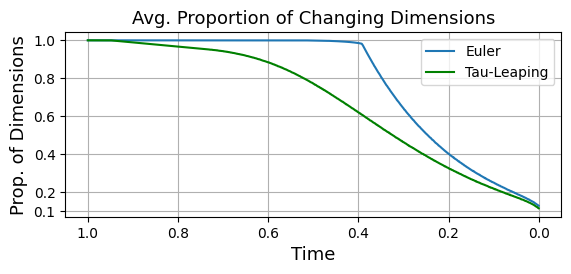

In [37]:
#np.save('PNGs/changing_dim_lbjf.npy', changes)
#np.save('PNGs/changing_dim_taul.npy', changes_jump)
import matplotlib.pyplot as plt
import numpy as np
width = 6.4
height= 2.4
#changes_dim = np.load('changing_dims_mnist_taul.npy')
changes_dim= np.load('PNGs/MNIST/changing_dim_taul.npy')
changes_jump_lbjf = np.load('PNGs/MNIST/changing_dim_lbjf.npy')
steps = np.linspace(1, 0, len(changes_dim[:-1]))
print(changes_dim)
print(changes_dim[4])
changes_dim[:50] = np.ones(50)
changes_dim[50:250] = np.linspace(1, changes_dim[250], len(changes_dim[:250]) - len(changes_dim[:50]))


fig = plt.figure(figsize=(width, height))
plt.gca().invert_xaxis()
plt.plot(steps, changes_jump_lbjf[:-1], label='Euler')
plt.plot(steps, changes_dim[:-1], label='Tau-Leaping', color='green')
#plt.plot(steps, changes_dim[:-1], label='Tau-Leaping 2')
plt.xlabel('Time', fontsize=13)
plt.ylabel('Prop. of Dimensions', fontsize=13)
plt.title('Avg. Proportion of Changing Dimensions', fontsize=13)
plt.legend()
plt.grid(True)

steps_y = [1.0, 0.8, 0.6, 0.4, 0.2, 0.1]
plt.yticks(steps_y, steps_y)
plt.savefig('changing_dim.pdf', format='pdf',bbox_inches="tight", transparent=True,   bbox_extra_artists=[plt.xlabel('Time', fontsize=13)], pad_inches=0.03)
plt.show()

In [ ]:
import numpy as np

# Definiere die Anzahl der Stufen und den maximalen Wert
num_steps = len(changes_dim[:250])
max_value = changes_dim[250]

# Definiere die Parameter für die nichtlineare Abnahme
start_factor = 1
end_factor = 0.1
decrease_rate = 0.9

# Erzeuge die Werte mit langsamer abnehmender Geschwindigkeit
values = []
factor = start_factor
for i in range(num_steps):
    value = max_value * factor
    values.append(value)
    factor *= decrease_rate
    if factor < end_factor:
        factor = end_factor

# Konvertiere die Werte in ein NumPy-Array
values = np.array(values)


In [ ]:
dataset = dataset_utils.get_dataset(cfg, device, dataset_location)

dataloader = torch.utils.data.DataLoader(dataset,
    batch_size=64,
    shuffle=cfg.data.shuffle)

#np.save('mazes3000_auxprotein2_lbjf.npy', saved_samples)
plot_number = 24
for true_dl in dataloader:
    true_dl = true_dl.reshape(-1, 1, 28, 28).cpu().numpy()

    plot_number = 24
    fig, axs = plt.subplots(4, 6, figsize=(6.1, 4.1))
    plt.subplots_adjust(wspace=0, hspace=0)  # Entfernen Sie den Abstand zwischen den Subplots

    # Schleife durch die Daten und die Subplots
    for i in range(plot_number):
        row = i // 6
        col = i % 6
        ax = axs[row, col]
        ax.axis('off')
        ax.imshow(np.transpose(true_dl[i, ...], (1, 2, 0)), cmap='gray')

    # Speichern oder Anzeigen des Plots
    plt.savefig('mnist_data.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()
    break

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Nehmen Sie an, dass "true_dl" Ihre MNIST-Daten enthält

plot_number = 24
fig, axs = plt.subplots(4, 6, figsize=(6.1, 4.1))
plt.subplots_adjust(wspace=0, hspace=0)  # Entfernen Sie den Abstand zwischen den Subplots

# Schleife durch die Daten und die Subplots
for i in range(plot_number):
    row = i // 6
    col = i % 6
    ax = axs[row, col]
    ax.axis('off')
    ax.imshow(np.transpose(true_dl[i, ...], (1, 2, 0)), cmap='gray')

# Speichern oder Anzeigen des Plots
plt.savefig('mnist_data.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

